# Semantic Segmentation

*General structure following [fast.ai notebook on camvid](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson3-camvid.ipynb)*

In [1]:
# No need to reload the notebook if any change in the fastai library
%reload_ext autoreload
%autoreload 2

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
from pathlib import Path
import PIL

from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from fastai.callbacks.tracker import SaveModelCallback

# Load Data

### We use the [Berkely Deep Drive Dataset](https://bdd-data.berkeley.edu/) which contains a rich labeled dataset for image segmentation in diverse conditions (weather, city, reference car…).

In [3]:
path_data = Path('/home/ruslan/Desktop/SelfDrivingCar/open_source/Semantic_Segmentation/semantic-segmentation/data/bdd100k/seg/')
path_lbl = path_data/'labels'
path_img = path_data/'images'

### Images and labels filenames

In [4]:
fnames = get_image_files(path_img, recurse = True)
fnames[:3]

[PosixPath('/home/ruslan/Desktop/SelfDrivingCar/open_source/Semantic_Segmentation/semantic-segmentation/data/bdd100k/seg/images/val/830c6cb2-6b35fcf9.jpg'),
 PosixPath('/home/ruslan/Desktop/SelfDrivingCar/open_source/Semantic_Segmentation/semantic-segmentation/data/bdd100k/seg/images/val/9a5d0ab3-00000000.jpg'),
 PosixPath('/home/ruslan/Desktop/SelfDrivingCar/open_source/Semantic_Segmentation/semantic-segmentation/data/bdd100k/seg/images/val/7f1d11ea-fdf50000.jpg')]

In [5]:
lbl_names = get_image_files(path_lbl, recurse = True)
lbl_names[:3]

[PosixPath('/home/ruslan/Desktop/SelfDrivingCar/open_source/Semantic_Segmentation/semantic-segmentation/data/bdd100k/seg/labels/val/a91b7555-00000390_train_id.png'),
 PosixPath('/home/ruslan/Desktop/SelfDrivingCar/open_source/Semantic_Segmentation/semantic-segmentation/data/bdd100k/seg/labels/val/a70efb84-00000000_train_id.png'),
 PosixPath('/home/ruslan/Desktop/SelfDrivingCar/open_source/Semantic_Segmentation/semantic-segmentation/data/bdd100k/seg/labels/val/96dd1db0-e186788a_train_id.png')]

### Take a look at the image data we have

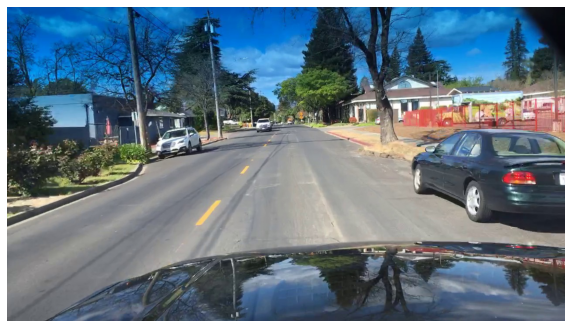

In [6]:
img_f = fnames[10]
img = open_image(img_f)
img.show(figsize=(10,10))

### Now we need to create a function that maps from the path of an image to the path of its segmentation.

In [7]:
get_y_fn = lambda x: path_lbl/x.parts[-2]/f'{x.stem}_train_id.png'

img_f, get_y_fn(img_f)

(PosixPath('/home/ruslan/Desktop/SelfDrivingCar/open_source/Semantic_Segmentation/semantic-segmentation/data/bdd100k/seg/images/val/a7e76c3d-4ef7b669.jpg'),
 PosixPath('/home/ruslan/Desktop/SelfDrivingCar/open_source/Semantic_Segmentation/semantic-segmentation/data/bdd100k/seg/labels/val/a7e76c3d-4ef7b669_train_id.png'))

### We can now use the obtained label path to open a segmentation image.

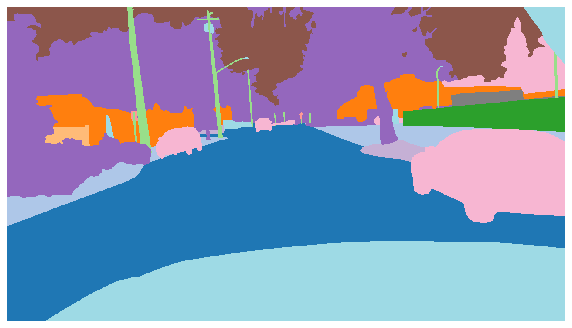

In [8]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(10,10), alpha=1)

In [9]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([ 720, 1280]), tensor([[[10, 10, 10,  ..., 19, 19, 19],
          [10, 10, 10,  ..., 19, 19, 19],
          [10, 10, 10,  ..., 19, 19, 19],
          ...,
          [ 0,  0,  0,  ..., 19, 19, 19],
          [ 0,  0,  0,  ..., 19, 19, 19],
          [ 0,  0,  0,  ..., 19, 19, 19]]]))

# Datasets

### Now that we know how our data looks like we can create our data-set using the SegmentationItemList class provided by FastAI.

In [10]:
# size = src_size//4
# bs = 32

size = src_size
bs = 2

In [11]:
# Classes extracted from dataset source code
# -> https://github.com/ucbdrive/bdd-data/blob/master/bdd_data/label.py

segmentation_classes = [
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light',
    'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car',
    'truck', 'bus', 'train', 'motorcycle', 'bicycle', 'void'
]
void_code = 19  # used to define accuracy and disconsider unlabeled pixels

In [12]:
src = (SegmentationItemList.from_folder(path_img) # Load in x data from folder
       .split_by_folder(train='train', valid='val') # Split data into training and validation set 
       .label_from_func(get_y_fn, classes = segmentation_classes)) # Label data using the get_y_fn function

In [13]:
src

LabelLists;

Train: LabelList (7000 items)
x: SegmentationItemList
Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280)
y: SegmentationLabelList
ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280)
Path: /home/ruslan/Desktop/SelfDrivingCar/open_source/Semantic_Segmentation/semantic-segmentation/data/bdd100k/seg/images;

Valid: LabelList (1000 items)
x: SegmentationItemList
Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280),Image (3, 720, 1280)
y: SegmentationLabelList
ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280),ImageSegment (1, 720, 1280)
Path: /home/ruslan/Desktop/SelfDrivingCar/open_source/Semantic_Segmentation/semantic-segmentation/data/bdd100k/seg/images;

Test: None

In [14]:
src.train.y.loss_func

FlattenedLoss of CrossEntropyLoss()

### Perform data augmentation and create databunch

In [15]:
# Define transformations to apply 
import numpy as np

train_tfms = [
        brightness(change=(0.1, 0.9), p=0.5),
        rotate(degrees=(-20,20), p=0.5),
        contrast(scale=(0.5, 2.), p=0.5),
        jitter(magnitude=np.random.uniform(-0.05, 0.05), p=0.1),
        symmetric_warp(magnitude=(-0.2,0.2), p=0.5),
        zoom(scale=np.random.uniform(1,1.6), p=0.5)
]

valid_tfms = []
# valid_tfms = train_tfms

# transformations = [train_tfms, valid_tfms]
transformations = get_transforms()

data = (src.transform(transformations, size=size, tfm_y=True)
        .databunch(bs=bs) # Create a databunch
        .normalize(imagenet_stats)) # Normalize for resnet

### We can show a few examples using the show_batch method which is available for all sorts of databunches

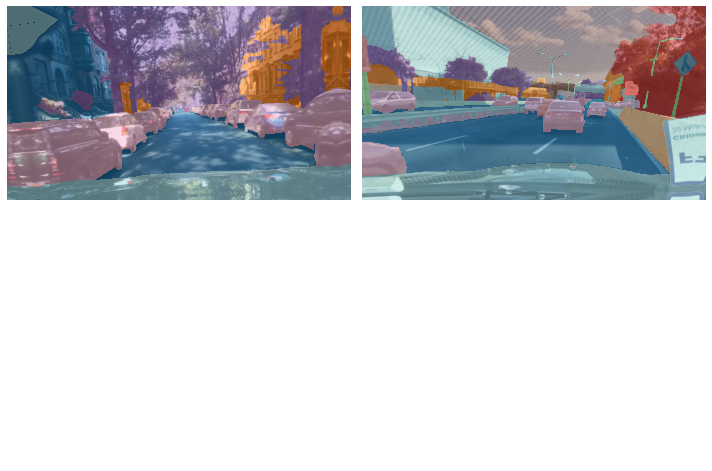

In [16]:
data.show_batch(2, figsize=(10,7))
# data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

It is also possible to create annotated segmenatation data from scratch by youe own, using such tools as:
https://github.com/abreheret/PixelAnnotationTool

## Model creation and training

A function that will measure the accuracy of the model. The accuracy in an image segmentation problem is the same as that in any classification problem.

Accuracy = no of correctly classified pixels / total pixels

However in this case, some pixels are labelled as Void and shouldn’t be considered when calculating the accuracy. Hence we make a new function for accuracy where we avoid those labels.

In [17]:
def acc(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [18]:
iou = partial(dice, iou=True)
f_score = partial(fbeta, thresh=0.2)
# metrics=[acc, iou, f_score]
metrics=[acc]

wd=1e-5 # weight decay

To create a U-NET in FastAI the unet_learner class can be used. We not only going to pass it our data but we will also specify an encoder-network (Resnet34 in our case), our accuracy function as well as a weight-decay

In [19]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd).to_fp16()

With our model ready to go we can now search for a fitting learning rate and then start training our model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


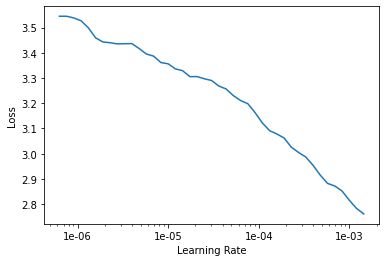

In [20]:
lr_find(learn)
learn.recorder.plot()

To read about picking a learning rate, go to:
https://towardsdatascience.com/fastai-image-classification-32d626da20
We need to select a point on the graph with the fastest decrease in the loss.

In [21]:
lr=3e-3 # pick a learning rate

In [ ]:
learn.fit_one_cycle(5, slice(lr), pct_start=0.9)

# learn.fit_one_cycle(10, slice(lr),
#                     callbacks=[SaveModelCallback(learn, name='best_model', every='epoch', monitor='accuracy')])#, pct_start=0.9) # train model

epoch,train_loss,valid_loss,acc,time


Standardly only the decoder is unfrozen, which means that our pretrained encoder didn’t receive any training yet so we will now show some results and then train the whole model.

In [ ]:
import os
current_path = os.getcwd()
# learn.save(current_path + '/trained_models/berkeley-stage-1') # save model
learn.save('berkeley-full-size')
learn.show_results(rows=3, figsize=(20,10))

### Perform fine-tuning of all layers

In [ ]:
# learn.load(current_path + '/trained_models/berkeley-stage-1');
learn.load('berkeley-full-size');

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
learn.unfreeze() # unfreeze all layers

In [ ]:
lrs = slice(lr/400,lr/4)

In [ ]:
# train the model
learn.fit_one_cycle(10, lrs)

In [ ]:
# learn.save(current_path + '/trained_models/berkeley-stage-2', return_path=True)
learn.save('berkeley-full-size')

In [41]:
# print(learn.summary())

# Transfer learning

In [21]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
bs = 32
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=32, have 7112MB of GPU RAM free


In [19]:
data = (src.transform(transformations, size=size, tfm_y=True)
        .databunch(bs=bs) # Create a databunch
        .normalize(imagenet_stats)) # Normalize for resnet

In [25]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd).to_fp16()

In [26]:
import os
current_path = os.getcwd()

learn.load(current_path + '/trained_models/berkeley-stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


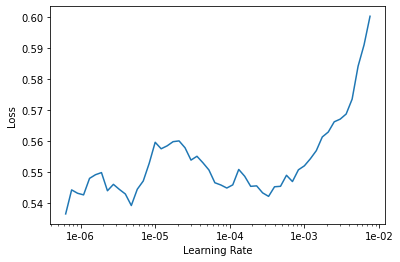

In [27]:
lr_find(learn)
learn.recorder.plot()

In [28]:
lr = 1e-4

In [29]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc,time
0,0.552319,0.476814,0.869082,02:02
1,0.561379,0.476085,0.869514,02:01
2,0.561146,0.475444,0.871277,02:01
3,0.556233,0.472648,0.871226,02:01
4,0.540644,0.469023,0.874355,02:01
5,0.545053,0.469354,0.874049,02:01
6,0.539720,0.466154,0.875369,02:01
7,0.535889,0.461191,0.875462,02:01
8,0.523310,0.456460,0.877061,02:01
9,0.531801,0.457275,0.876733,02:01


In [30]:
learn.save(current_path + '/trained_models/berkeley-stage-2')

## Model evaluation on test dataset

In [42]:
# Training and testing databunch creation
data_test = (SegmentationItemList.from_folder(path_img)
            .split_by_folder(train='train', valid='test')
            .label_from_func(get_y_fn, classes = segmentation_classes)
#             .transform(transformations)
            .databunch(bs=bs)
            .normalize(imagenet_stats))

# learn = unet_learner(data_test, models.resnet34, metrics=metrics, wd=wd);
learn.load(current_path + '/trained_models/berkeley-stage-2');

In [25]:
preds,_ = learn.get_preds(ds_type=SegmentationItemList) 
labels = np.argmax(preds, 1)

In [30]:
labels[0]

tensor([[ 8,  8,  8,  ..., 19, 19, 19],
        [ 8,  8,  8,  ..., 19, 19, 19],
        [ 8,  8,  8,  ..., 19, 19, 19],
        ...,
        [19, 19, 19,  ..., 19, 19, 19],
        [19, 19, 19,  ..., 19, 19, 19],
        [19, 19, 19,  ..., 19, 19, 19]])

## Making predictions

In [ ]:
# learn.load(current_path + '/trained_models/berkeley-stage-2');
learn.load('berkeley-full-size')

### Image inference

In [ ]:
test_img = open_image('/home/ruslan/Desktop/example_images/example_04.png')

import time
start = time.time()
output = learn.predict( test_img )
print('Inference took %.4f [sec]'%(time.time()-start))

print('Original shape:', test_img.shape)
test_resized = test_img.apply_tfms(None, size=output[0].shape)
print('Resized shape:', test_resized.shape)

test_resized.show(figsize=(10,10), y=learn.predict(test_resized)[0])

### Video inference

In [ ]:
def np_img2fastai_img(np_img):
    img_fastai = Image(pil2tensor(np_img, dtype=np.float32).div_(255))
    return img_fastai

In [ ]:
import imutils
import cv2
from tqdm import tqdm

vs = cv2.VideoCapture('../data/videos/moscow_streets.mp4')
writer = None

# try to determine the total number of frames in the video file
try:
    prop =  cv2.cv.CV_CAP_PROP_FRAME_COUNT if imutils.is_cv2() \
        else cv2.CAP_PROP_FRAME_COUNT
    total = int(vs.get(prop))
    print("[INFO] {} total frames in video".format(total))
# an error occurred while trying to determine the total
# number of frames in the video file
except:
    print("[INFO] could not determine # of frames in video")
    total = -1

np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(segmentation_classes) - 1, 3), dtype="uint8")
COLORS = np.vstack([COLORS, [0, 0, 0]]).astype("uint8")

while(1):
# for i in tqdm( range(30) ):
    # get raw frames from video stream
    ret, frame = vs.read()
    if ret == False:
        break
    # preprocess raw frames
    start = time.time()
    frame_fastai = np_img2fastai_img(frame)
    output = learn.predict( frame_fastai )
    end = time.time()
#     print("[INFO] single frame took {:.4f} seconds".format(end-start))
    
    # check if the video writer is None
    if writer is None:
        # initialize our video writer
        fourcc = cv2.VideoWriter_fourcc(*"MJPG")
        writer = cv2.VideoWriter('../data/videos/moscow_output_berkeley.avi', fourcc, 30,
            (size[1], size[0]), True)

        # some information on processing single frame
        if total > 0:
            elap = (end - start)
            print("[INFO] single frame took {:.4f} seconds".format(elap))
            print("[INFO] estimated total time: {:.4f} [min]".format(elap * total/60.))

    # preprocess output frames before writing to disk
    classMap = np.array(output[1][0], dtype=np.uint8)
    mask = COLORS[classMap]
    frame_resized = cv2.resize(frame, (size[1], size[0]), interpolation = cv2.INTER_AREA)
    output_to_write = (0.3 * frame_resized + 0.7 * mask).astype("uint8")
    # write the output frame to disk
    writer.write(output_to_write)